# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12399, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 12399 (delta 5), reused 14 (delta 2), pack-reused 12380
Receiving objects: 100% (12399/12399), 12.13 MiB | 9.37 MiB/s, done.
Resolving deltas: 100% (8548/8548), done.
/content/yolov5


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
%cd /content/yolov5

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to American-Mushrooms-1 in yolov5pytorch:: 100%|██████████| 278/278 [00:00<00:00, 1111.85it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {'/content/drive/MyDrive/cropvsweed'}/data.yaml

train: /content/drive/MyDrive/cropvsweed/train/images
val: /content/drive/MyDrive/cropvsweed/valid/images

nc: 2
names: ['crop','weed']

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open('/content/drive/MyDrive/cropvsweed' + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# import shutil
# shutil.rmtree('/content/yolov5/runs')

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 512 --batch 16 --epochs 1000 --data {'/content/drive/MyDrive/cropvsweed'}/data.yaml --cfg ./models/custom_yolov5l.yaml --weights ''  --name yolov5l_cropweed  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5m.yaml, data=/content/drive/MyDrive/cropvsweed/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1000, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5m_cropweed, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-278-g1ab23fc Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, io

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

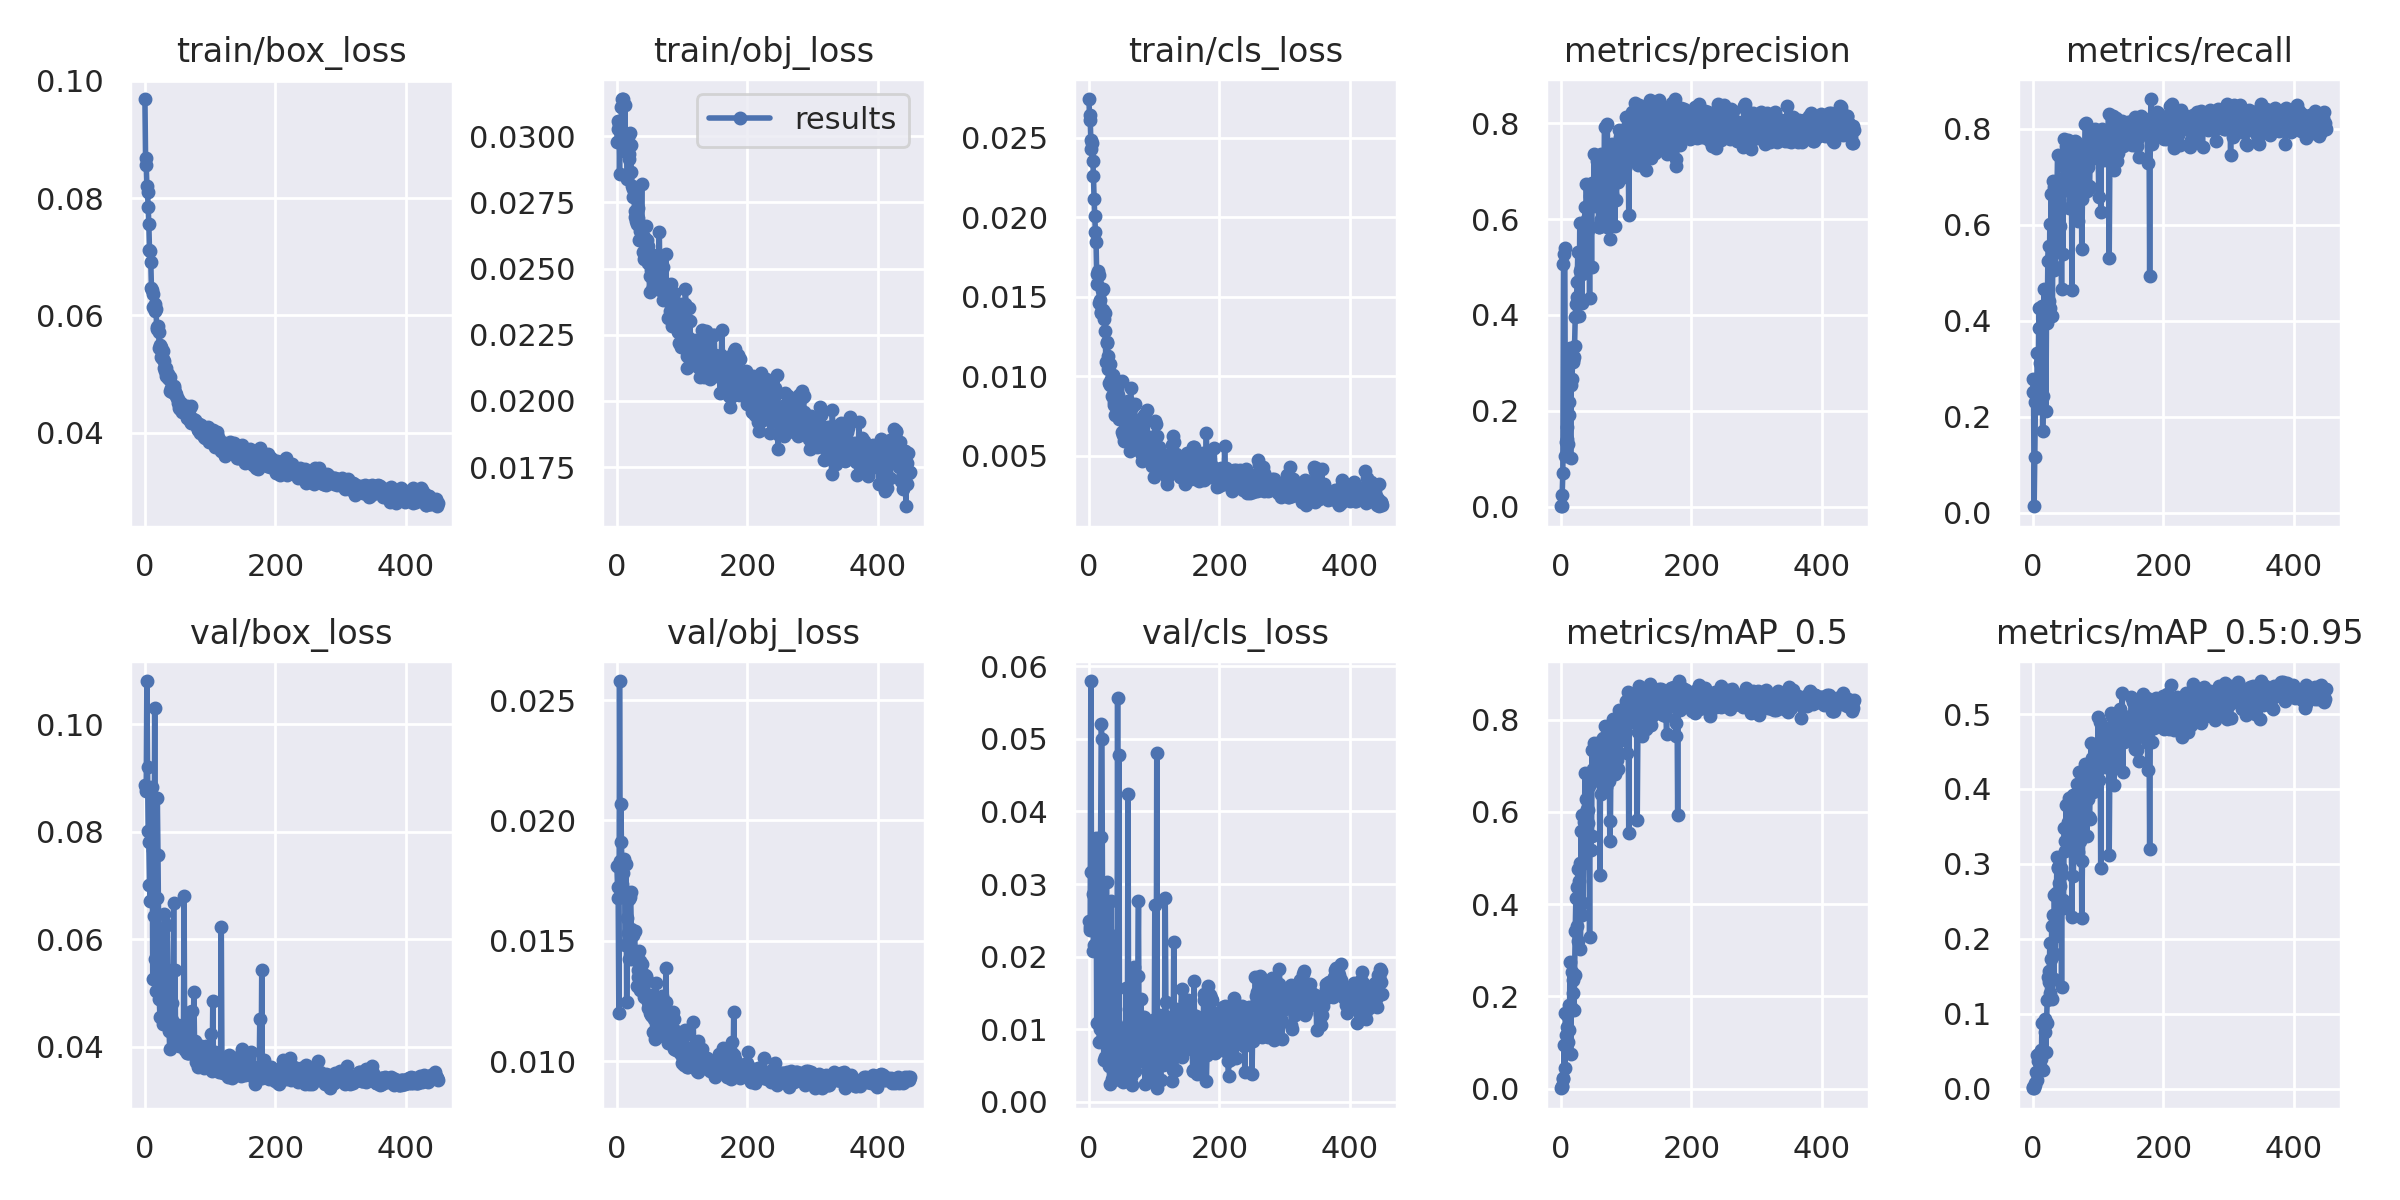

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5l_cropweed/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


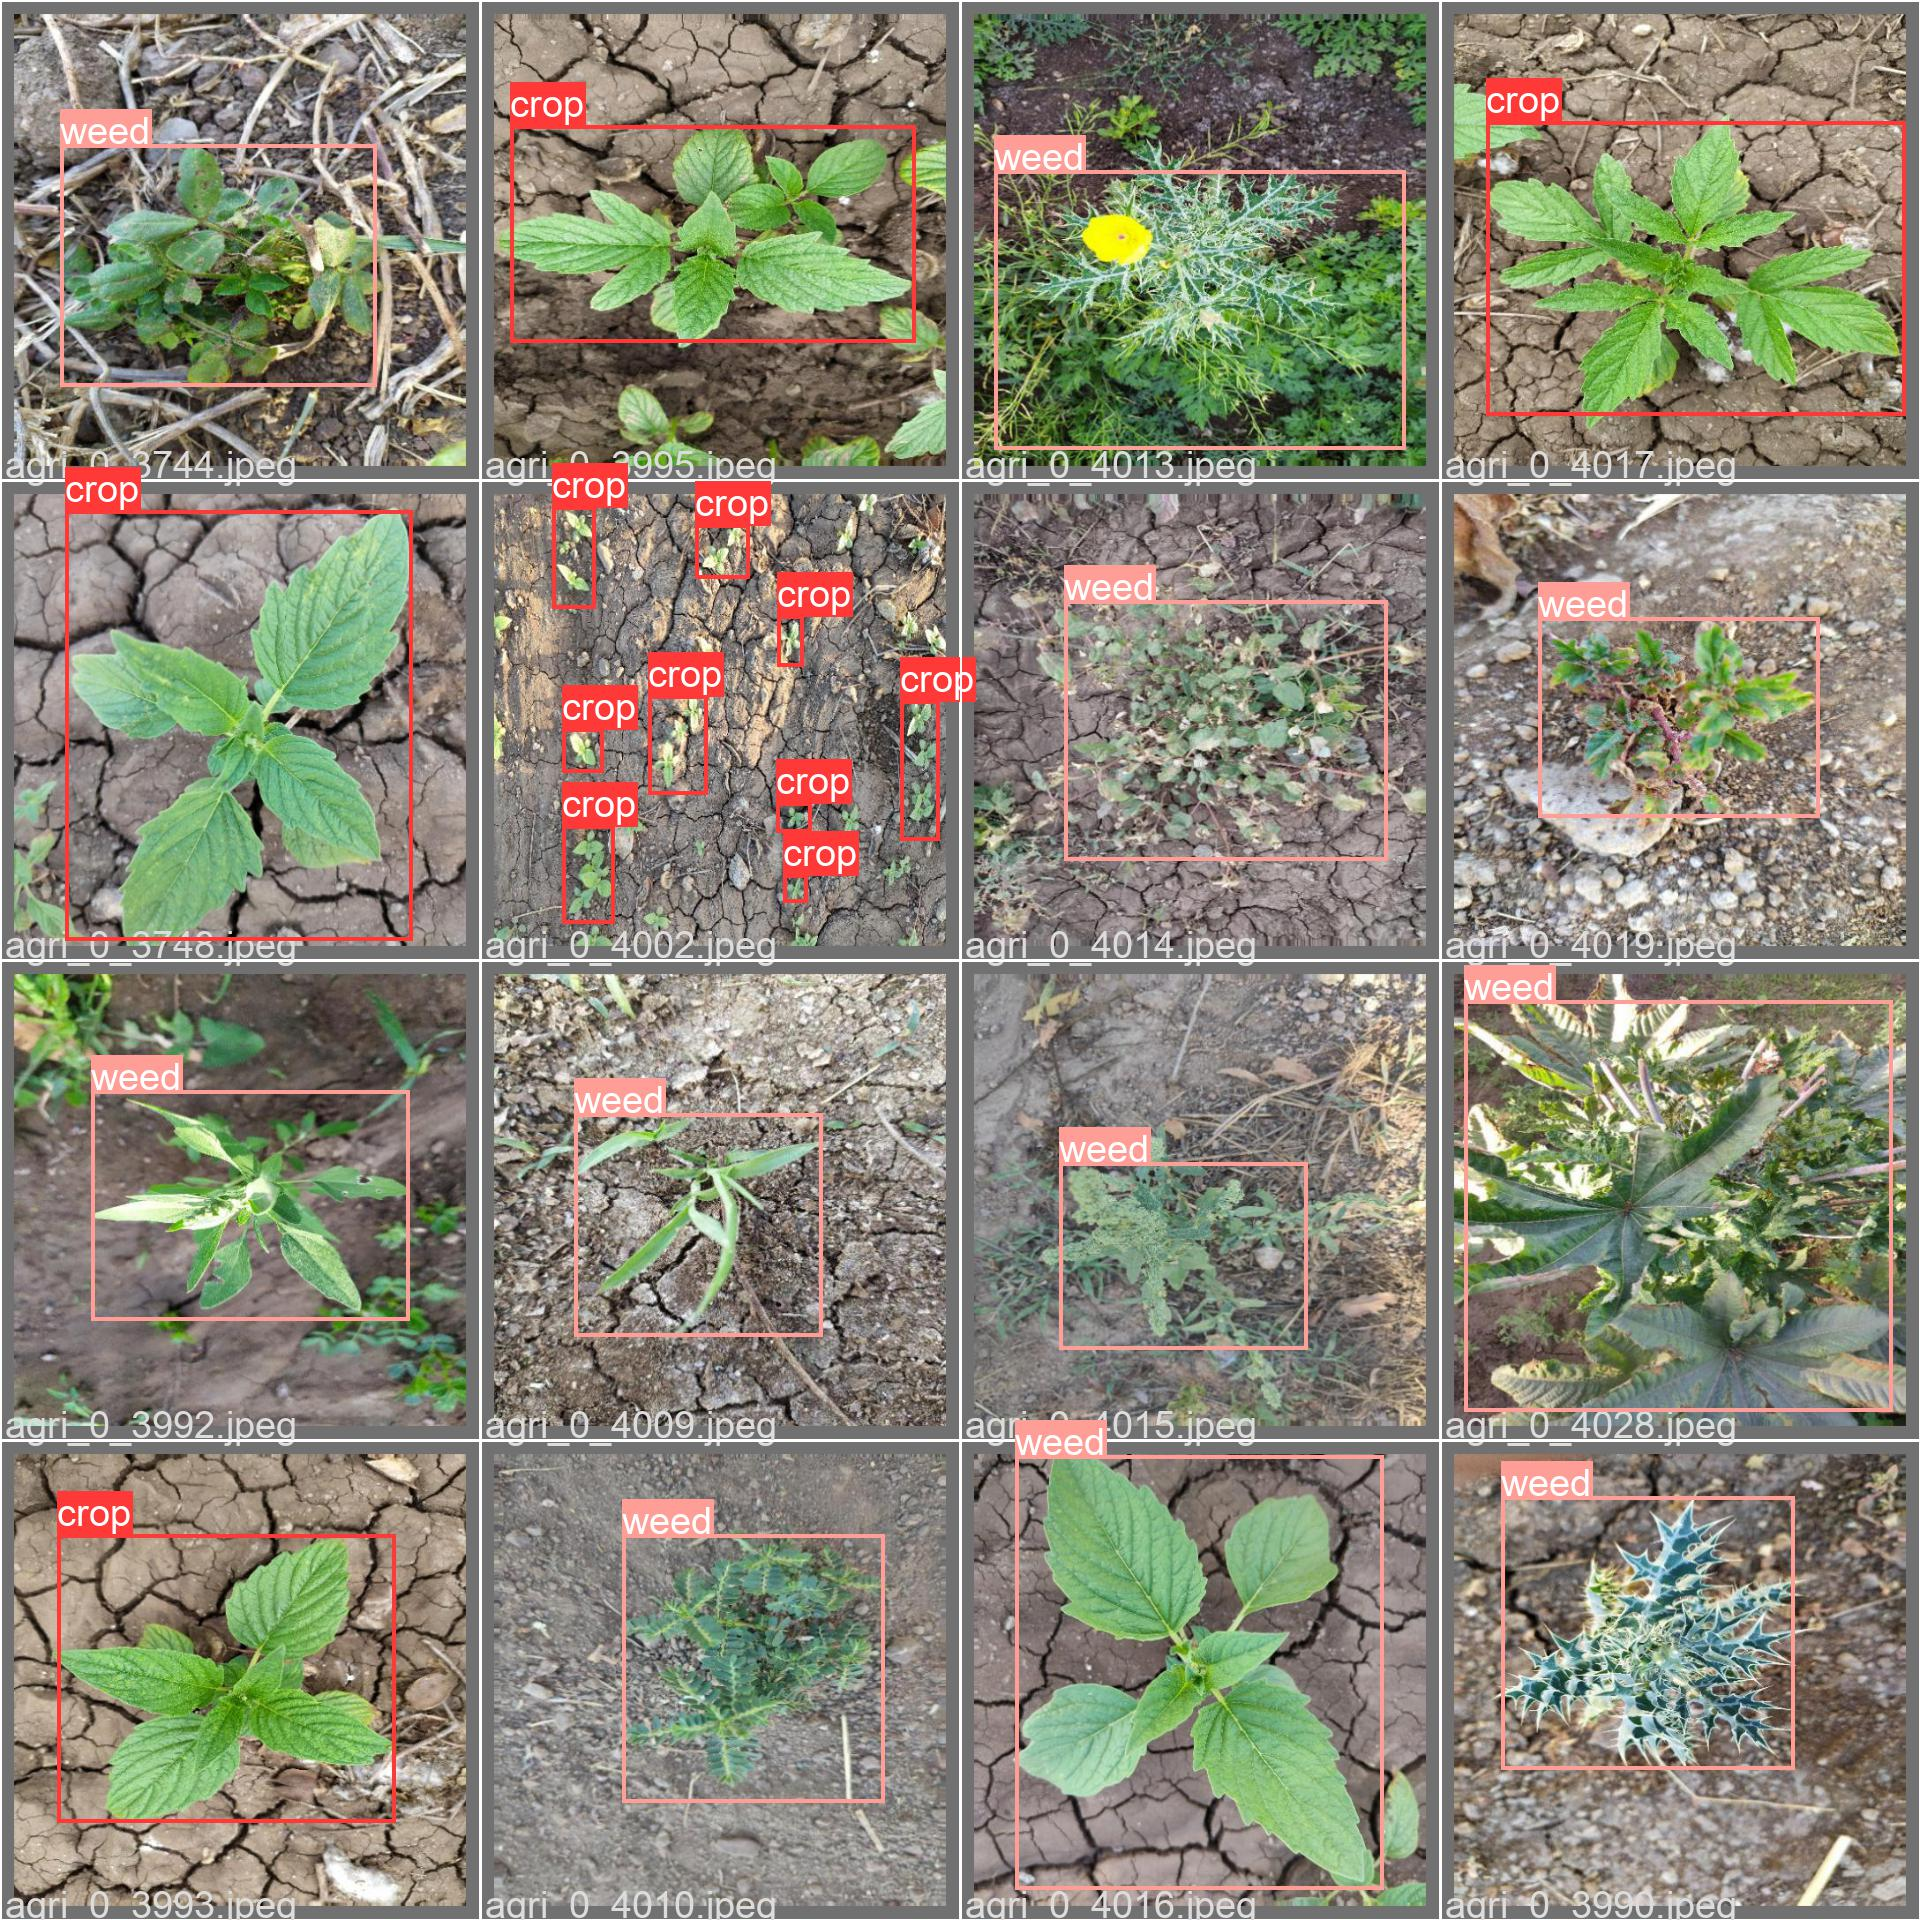

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5l_cropweed/val_batch2_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


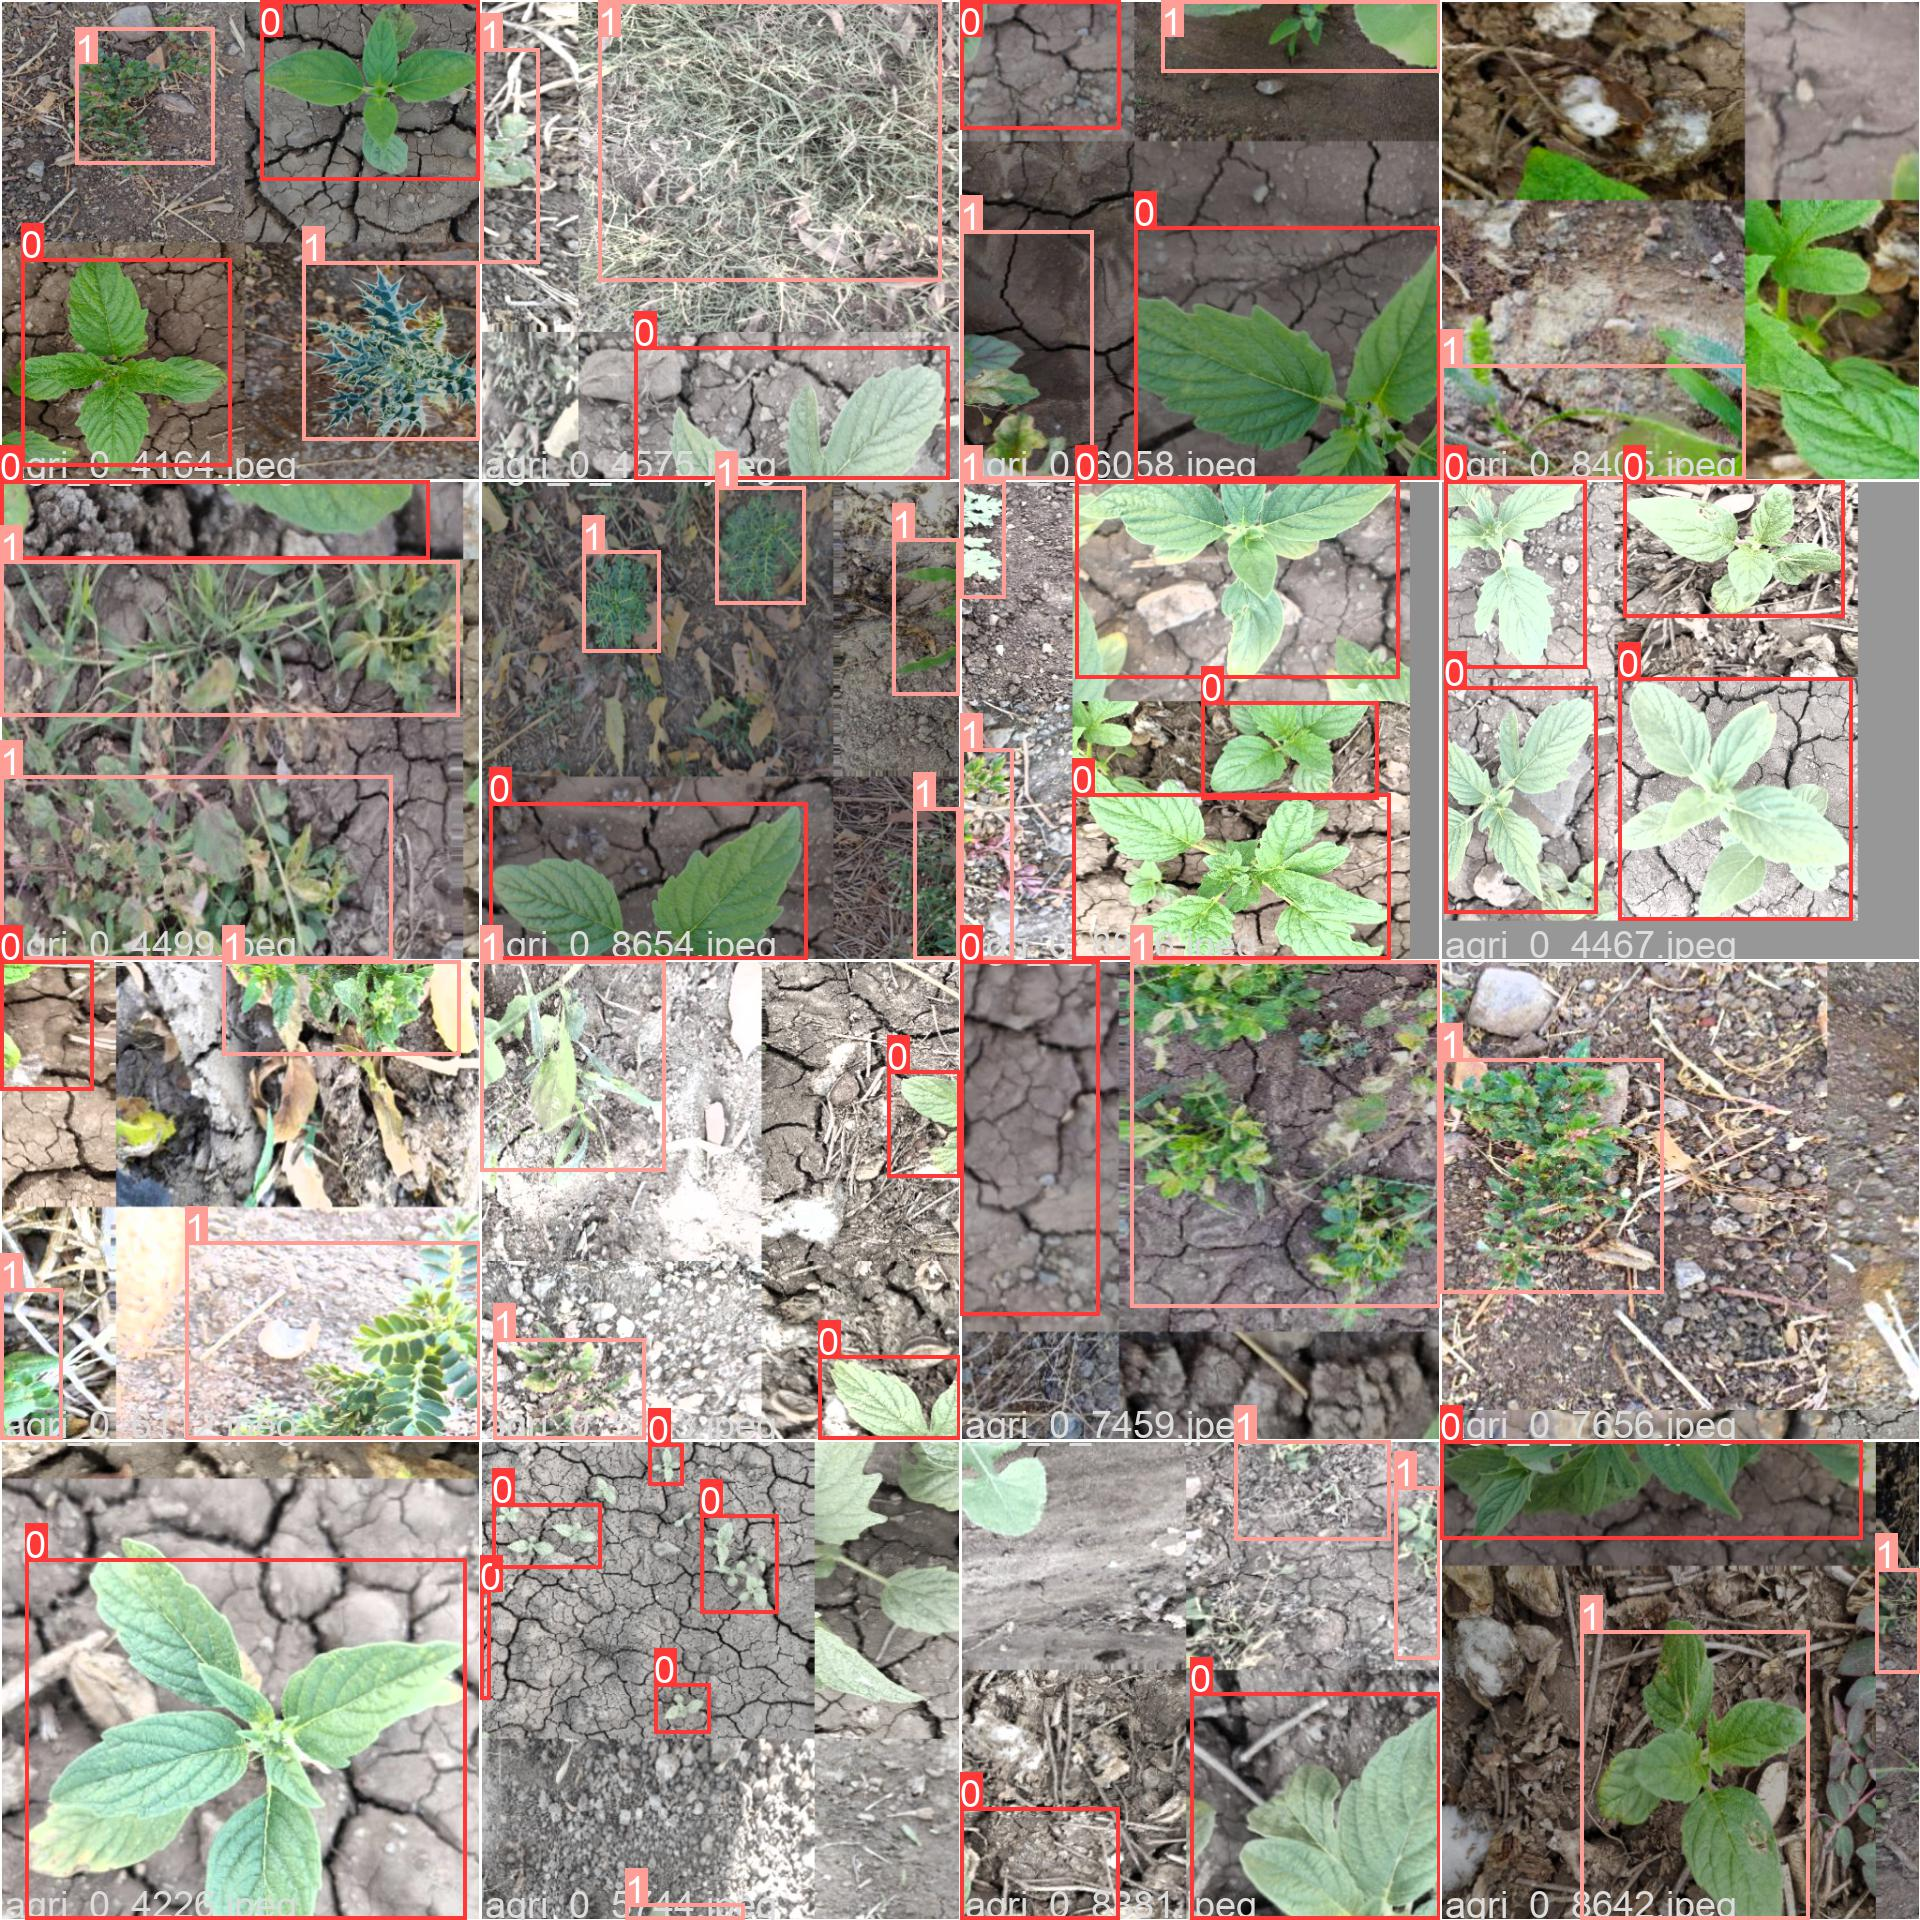

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5l_cropweed/train_batch0.jpg', width=1000)

# Run Evaluation With Trained Weights

In [ ]:
%cd /content/yolov5/
!python val.py  --batch 16 --data {'/content/drive/MyDrive/cropvsweed'}/data.yaml --weights runs/train/yolov5s_cropweed/weights/best.pt --task test --name 'Testing' --augment --verbose

In [ ]:
Image(filename='/content/yolov5/runs/val/Testing/P_curve.png', width=1000)

In [ ]:
Image(filename='/content/yolov5/runs/val/Testing/R_curve.png', width=1000)

In [ ]:
Image(filename='/content/yolov5/runs/val/Testing/PR_curve.png', width=1000)

In [ ]:
Image(filename='/content/yolov5/runs/val/Testing/F1_curve.png', width=1000)

In [ ]:
Image(filename='/content/yolov5/runs/val/Testing/confusion_matrix.png', width=1000)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5l_cropweed/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5l_cropweed/weights/best.pt --img 512 --conf 0.8 --source /content/drive/MyDrive/cropvsweed/test/images

/content/yolov5
detect: weights=['runs/train/yolov5m_cropweed/weights/best.pt'], source=/content/drive/MyDrive/cropvsweed/test/images, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.8, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-278-g1ab23fc Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPs
image 1/260 /content/drive/MyDrive/cropvsweed/test/images/agri_0_1009.jpeg: 512x512 Done. (0.013s)
image 2/260 /content/drive/MyDrive/cropvsweed/test/images/agri_0_1017.jpeg: 512x512 Done. (0.013s)
image 3/260 /content/drive/MyDrive/cropvsweed/test/images/agri_0_1018.jpeg: 512x512 Done. (0.057s)


In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpeg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5l_cropweed/weights/best.pt /content/drive/MyDrive

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)

In [ ]:
%cd /content/yolov5/
!python detect.py --source /content/drive/MyDrive/cropvsweed/test/images/agri_0_131.jpeg --weights /content/yolov5/runs/train/yolov5l_cropweed/weights/best.pt

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/cropvsweed/test/images/agri_0_131.jpeg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5m_cropweed/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPS
image 1/1 /content/drive/MyDrive/cropvsweed/test/images/agri_0_131.jpeg: 640x640 2 crops, Done. (0.020s)
Results saved to runs/dete

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-278-g1ab23fc Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPs
Adding AutoShape... 


Using Device:  cuda


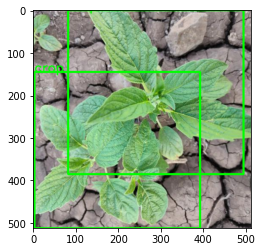

In [ ]:
import torch
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt


class MugDetection:
    """
    Class implements Yolo5 model to make inferences on a youtube video using Opencv2.
    """

    def __init__(self, capture_index, model_name):
        """
        Initializes the class with youtube url and output file.
        :param url: Has to be as youtube URL,on which prediction is made.
        :param out_file: A valid output file name.
        """
        self.capture_index = capture_index
        self.model = self.load_model(model_name)
        self.classes = self.model.names
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Using Device: ", self.device)

    def load_model(self, model_name):
        """
        Loads Yolo5 model from pytorch hub.
        :return: Trained Pytorch model.
        """
        if model_name:
            model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_name, force_reload=True)
        else:
            model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True)
        return model

    def score_frame(self, frame):
        """
        Takes a single frame as input, and scores the frame using yolo5 model.
        :param frame: input frame in numpy/list/tuple format.
        :return: Labels and Coordinates of objects detected by model in the frame.
        """
        self.model.to(self.device)
        frame = [frame]
        results = self.model(frame)
        labels, cord = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
        return labels, cord

    def class_to_label(self, x):
        """
        For a given label value, return corresponding string label.
        :param x: numeric label
        :return: corresponding string label
        """
        return self.classes[int(x)]

    def plot_boxes(self, results, frame):
        """
        Takes a frame and its results as input, and plots the bounding boxes and label on to the frame.
        :param results: contains labels and coordinates predicted by model on the given frame.
        :param frame: Frame which has been scored.
        :return: Frame with bounding boxes and labels ploted on it.
        """
        labels, cord = results
        n = len(labels)
        x_shape, y_shape = frame.shape[1], frame.shape[0]
        for i in range(n):
            row = cord[i]
            if row[4] >= 0.3:
                x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
                bgr = (0, 255, 0) if self.class_to_label(labels[i])=="crop" else (255, 0, 00)
                cv2.rectangle(frame, (x1, y1), (x2, y2), bgr, 4)
                cv2.putText(frame, self.class_to_label(labels[i]), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, bgr, 2)

        return frame

    def __call__(self):
        """
        This function is called when class is executed, it runs the loop to read the video frame by frame,
        and write the output into a new file.
        :return: void
        """
        img = cv2.imread('/content/drive/MyDrive/cropvsweed/test/images/agri_0_131.jpeg')
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        results = self.score_frame(img)
        frame = self.plot_boxes(results, img)
        plt.imshow(frame)
        plt.show()   
# Create a new object and execute.
detector = MugDetection(capture_index=0, model_name='/content/drive/MyDrive/best.pt')
detector()

In [ ]:
%cd /content/yolov5/
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/yolov5l_cropweed/weights/best.pt', force_reload=True)

/content/yolov5


Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-278-g1ab23fc Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPs
Adding AutoShape... 


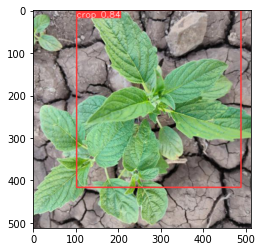

In [ ]:
import cv2
import torch
from PIL import Image
%matplotlib inline

# Model


# Images
img1 = Image.open('/content/drive/MyDrive/cropvsweed/test/images/agri_0_131.jpeg')  # PIL image


# Inference
results = model(img1)  # includes NMS

plt.imshow(np.squeeze(results.render()))
plt.show()